In [2]:
import numpy as np
import pylab as pl
from random import randint
import numpy as np
from pytisean import tiseanio
from matplotlib import pyplot as plt
from curvature import *
from subprocess import call
import pandas as pd
import os
from scipy.stats import gaussian_kde
print(os.getcwd())
from scipy import constants 
import scipy
from scipy.stats import powerlaw as scipypowerlaw

params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
from ensembles import plot_d2, fit_slopes, generate_individual_ensembles_ordered_fixed
from utils import peak, lin_interp, half_max_x
from scipy.stats import ks_2samp

/Users/varad/scaling_regions_ensemble


### Create an example "scaling law" relationship, to demonstrate the execution of the ensemble-based algorithm below.

This is preliminary a linear relationship x v/s y, with flat regions on the two ends of the line, and a sinusoidal noise perturbation on one side of the scaling region. This is the same example as Fig. 1 of the paper https://doi.org/10.1063/5.0069365.

We load the data from toy_example.txt (see toy_example.py for the generation code). Use this code to load your own two-dimensional relationship. First column should be the X-axis and second column the Y-axis. 


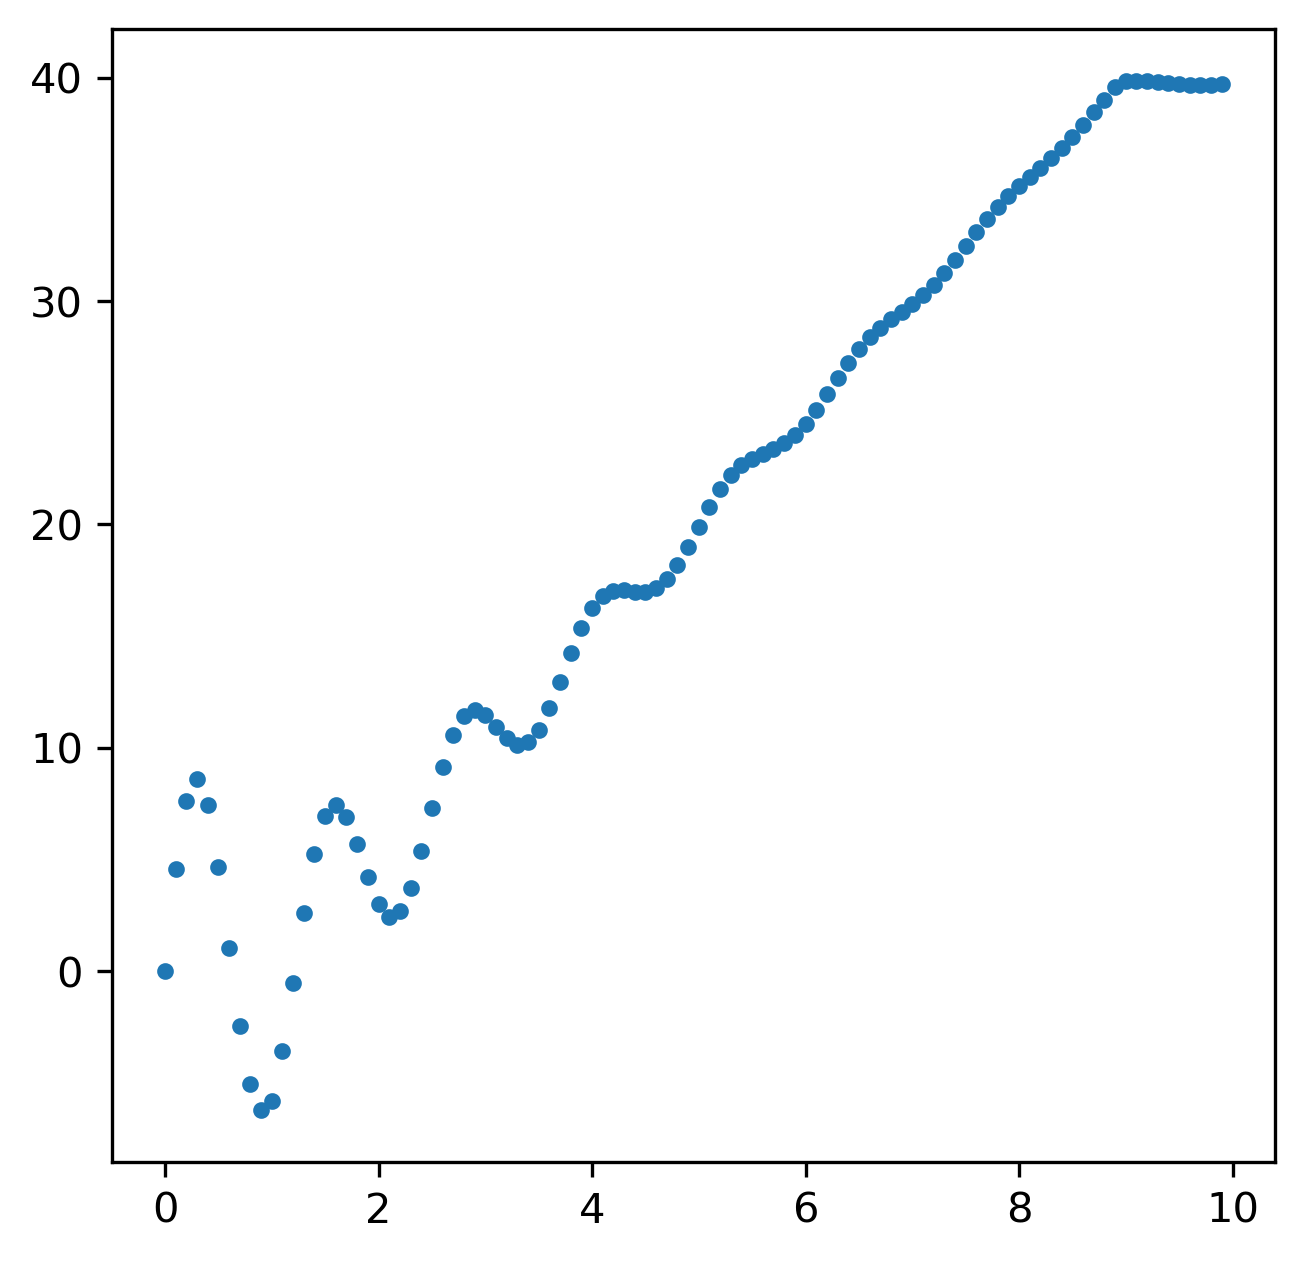

In [8]:
output_dir = 'toy/'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
region = np.loadtxt('toy_example.txt')

plt.figure(figsize=(8,6), dpi=300)
ax1 = plt.gca()
plt.plot(region[:,0], region[:,1], '.')


# Feed the 2D region into the ensemble-based algorithm. 

## The algorithm takes as arguments: 

#### region: The 2D array containing our scaling region plot. 
#### bounds: Upper and lower bounds on the X-axis to limit the region on which to run change-point detection. 
#### P_power: Exponent of the fit length in the weighting term. Higher exponent values favor longer scaling region fits. 
#### Q_power: Exponent of the fit error in the weighting term. Higher exponent values favor scaling region fits with lower fit errors. 

## The return values are: 

#### lhs_arr: The LHS markers of all the fits generated by the algorithm
#### rhs_arr: The RHS markers of all the fits generated by the algorithm
#### slope: The array of corresponding slopes for all the fits generated by the algorithm 
#### error: The fit errors for all the fits
#### weights: The weights of all the fits. The weighting term is given by $\frac{(\text{fit length})^\text{P_power}}{ (\text{fit error})^\text{Q_power}}$

In [9]:
P_power = 1
Q_power = 2

bounds = [region[0,0], region[-1,0]]
[lhs_arr, rhs_arr, slope, error, weights] = generate_individual_ensembles_ordered_fixed(region, bounds, P_power, Q_power)


# Generate a prob density function of the slopes. 

Weight by the proposed weighting scheme when generating PDF, and compute the mode and FWHM. This is Fig. 1(b) of the paper. 

Estimate of the scaling region slope 4.969939879759519
Confidence bounds ( 4.784133542093198 , 5.1481490886362 )
Error statistic =  0.10528196822896752
FWHM =  0.36401554654300217
Area within FWHM =  0.6687618103770802


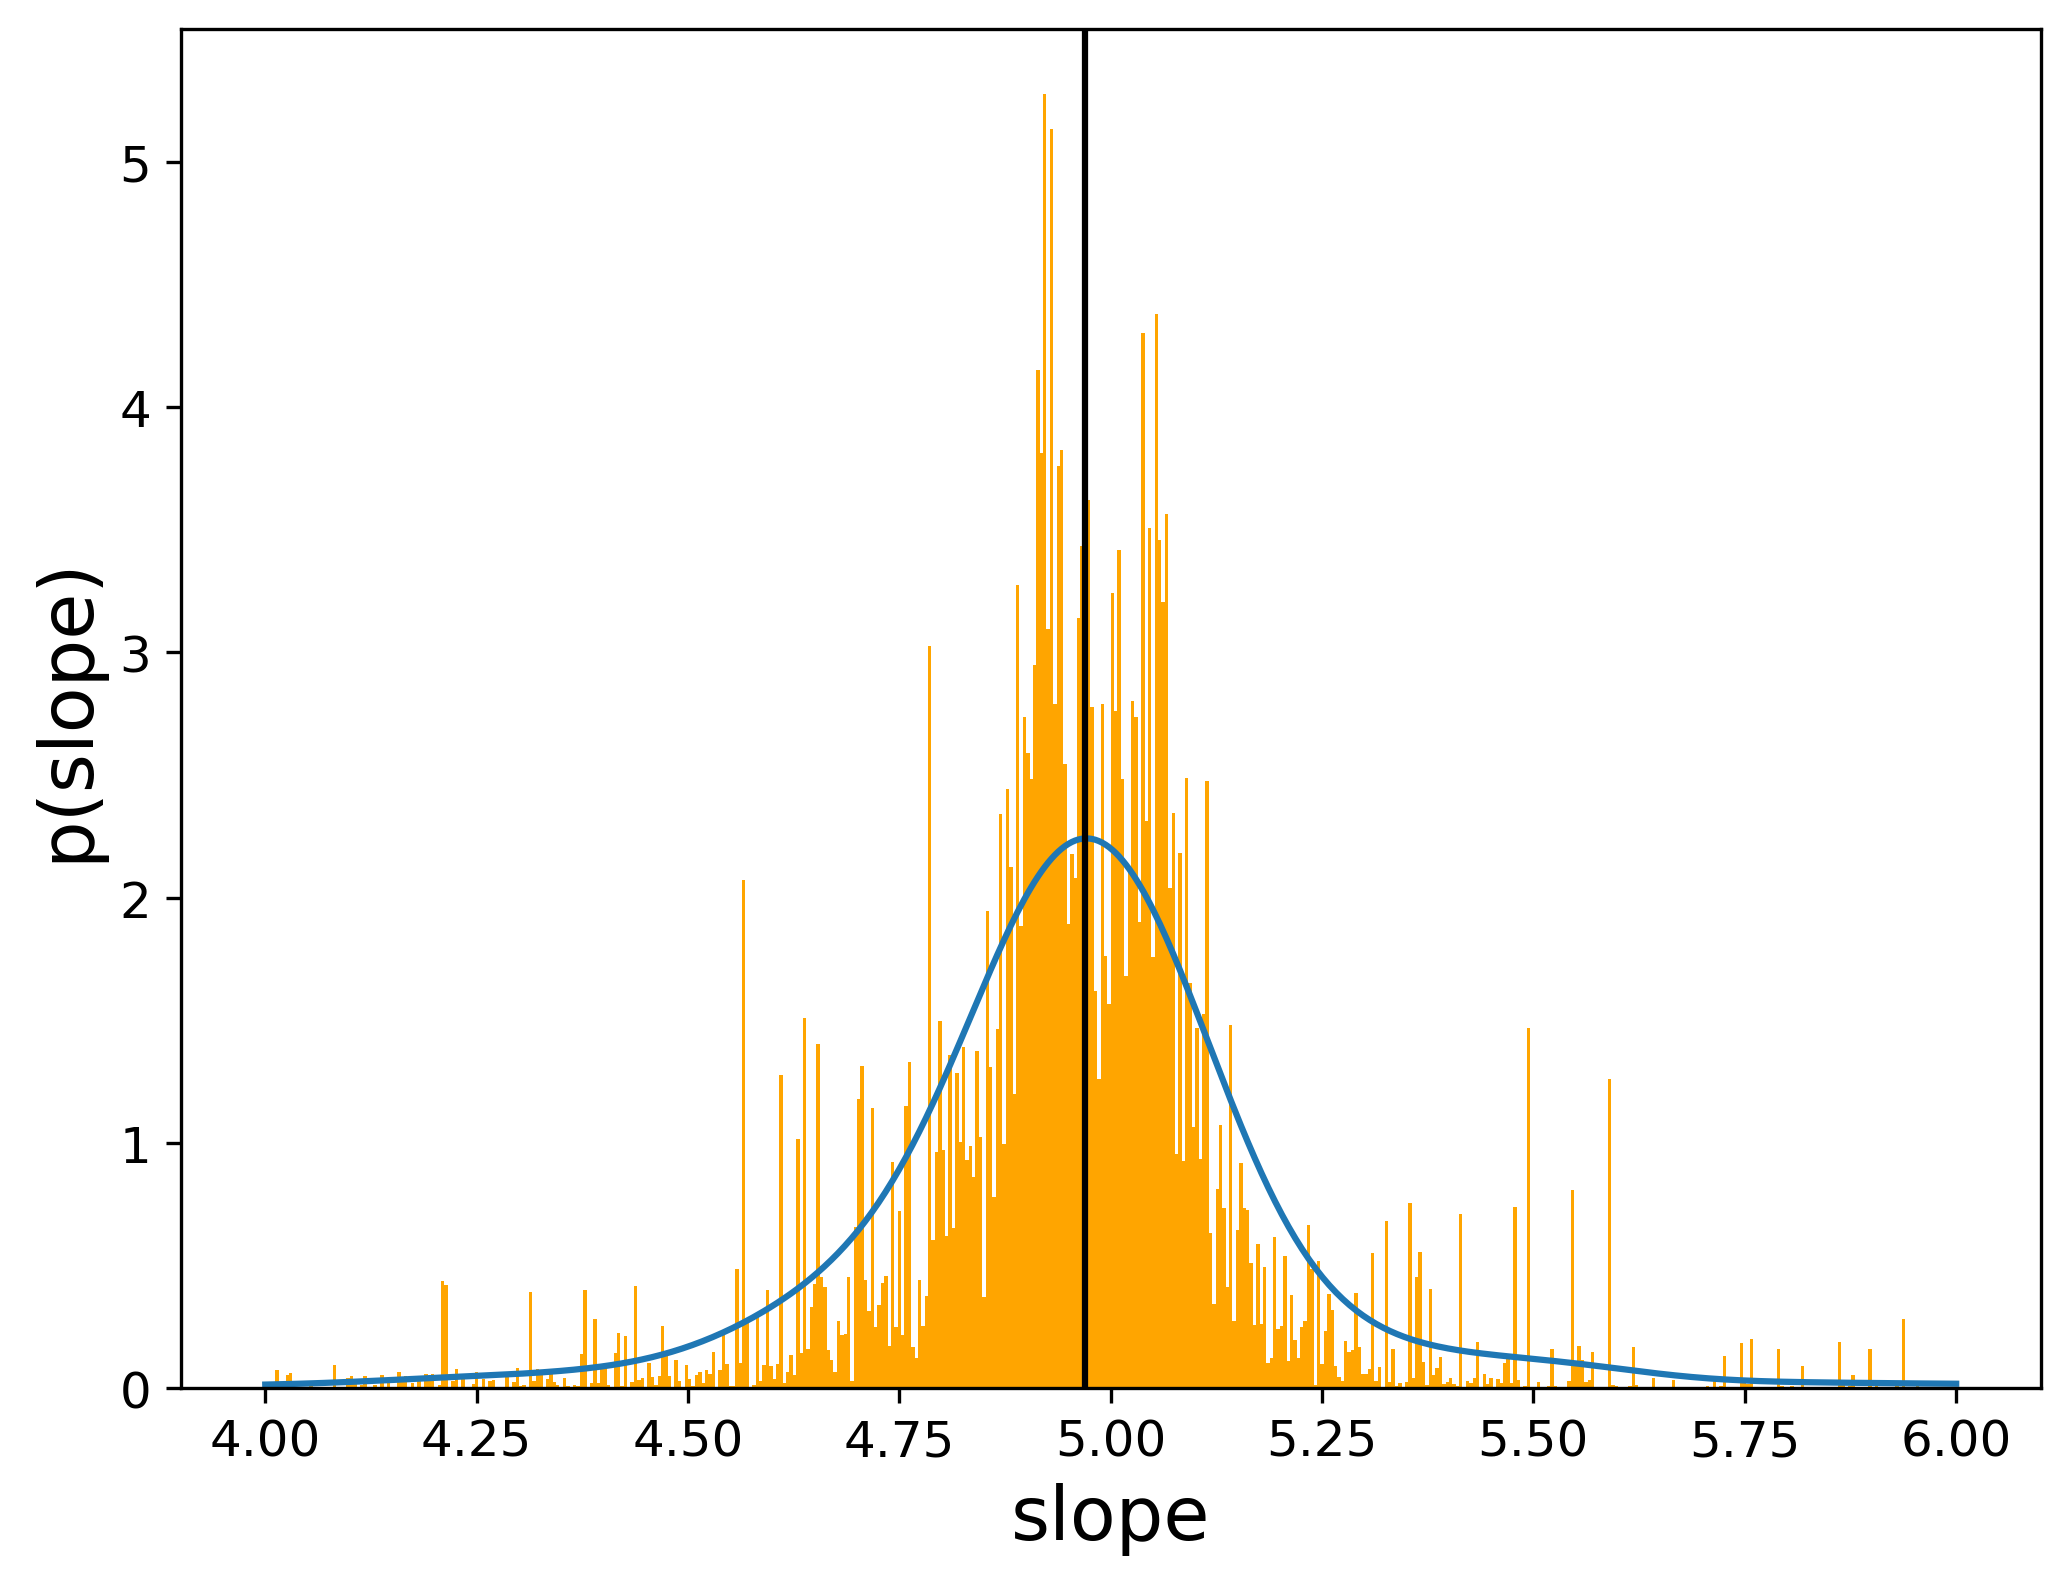

In [14]:
idx = ~np.isnan(slope)
slope = slope[idx]
weights = weights[idx]
kernel = gaussian_kde(slope, weights=weights)
positions = np.linspace(4, 6, num=500)
plt.figure(figsize=(8,6), dpi=300)
p = plt.plot(positions, kernel(positions))
color = p[0].get_color()
arr = plt.hist(slope, weights=weights, bins=500, range=(4,6), color='orange', density=True)
plt.axvline(x = positions[np.argmax(kernel(positions))], color='black')
plt.xlabel(r'slope', fontsize=18)
plt.ylabel(r'p(slope)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(output_dir + '/toy_example_full_pdf.png')

lower_x, upper_x = half_max_x(positions,kernel(positions))
mode = positions[np.argmax(kernel(positions))]

#print(lower_x, upper_x, mode)
print("Estimate of the scaling region slope", mode)
print("Confidence bounds", "(", lower_x, ",", upper_x, ")")
fwhm = positions[np.where(np.logical_and(positions <= upper_x, positions >= lower_x))]
print("Error statistic = ", np.std(positions[np.where(np.logical_and(positions <= upper_x, positions >= lower_x))]))
print("FWHM = ", upper_x - lower_x)
print("Area within FWHM = ", np.sum(kernel(fwhm)) / np.sum(kernel(positions)))

### Determine the LHS and RHS estimates of the scaling region.

Generate the LHS and RHS PDFs using a similar weighting scheme, and compute the modes. This is Fig. 1(c) of the paper. This is Fig. 1(c) of the paper. 

RHS Estimate = 8.92
LHS Estimate = 6.45


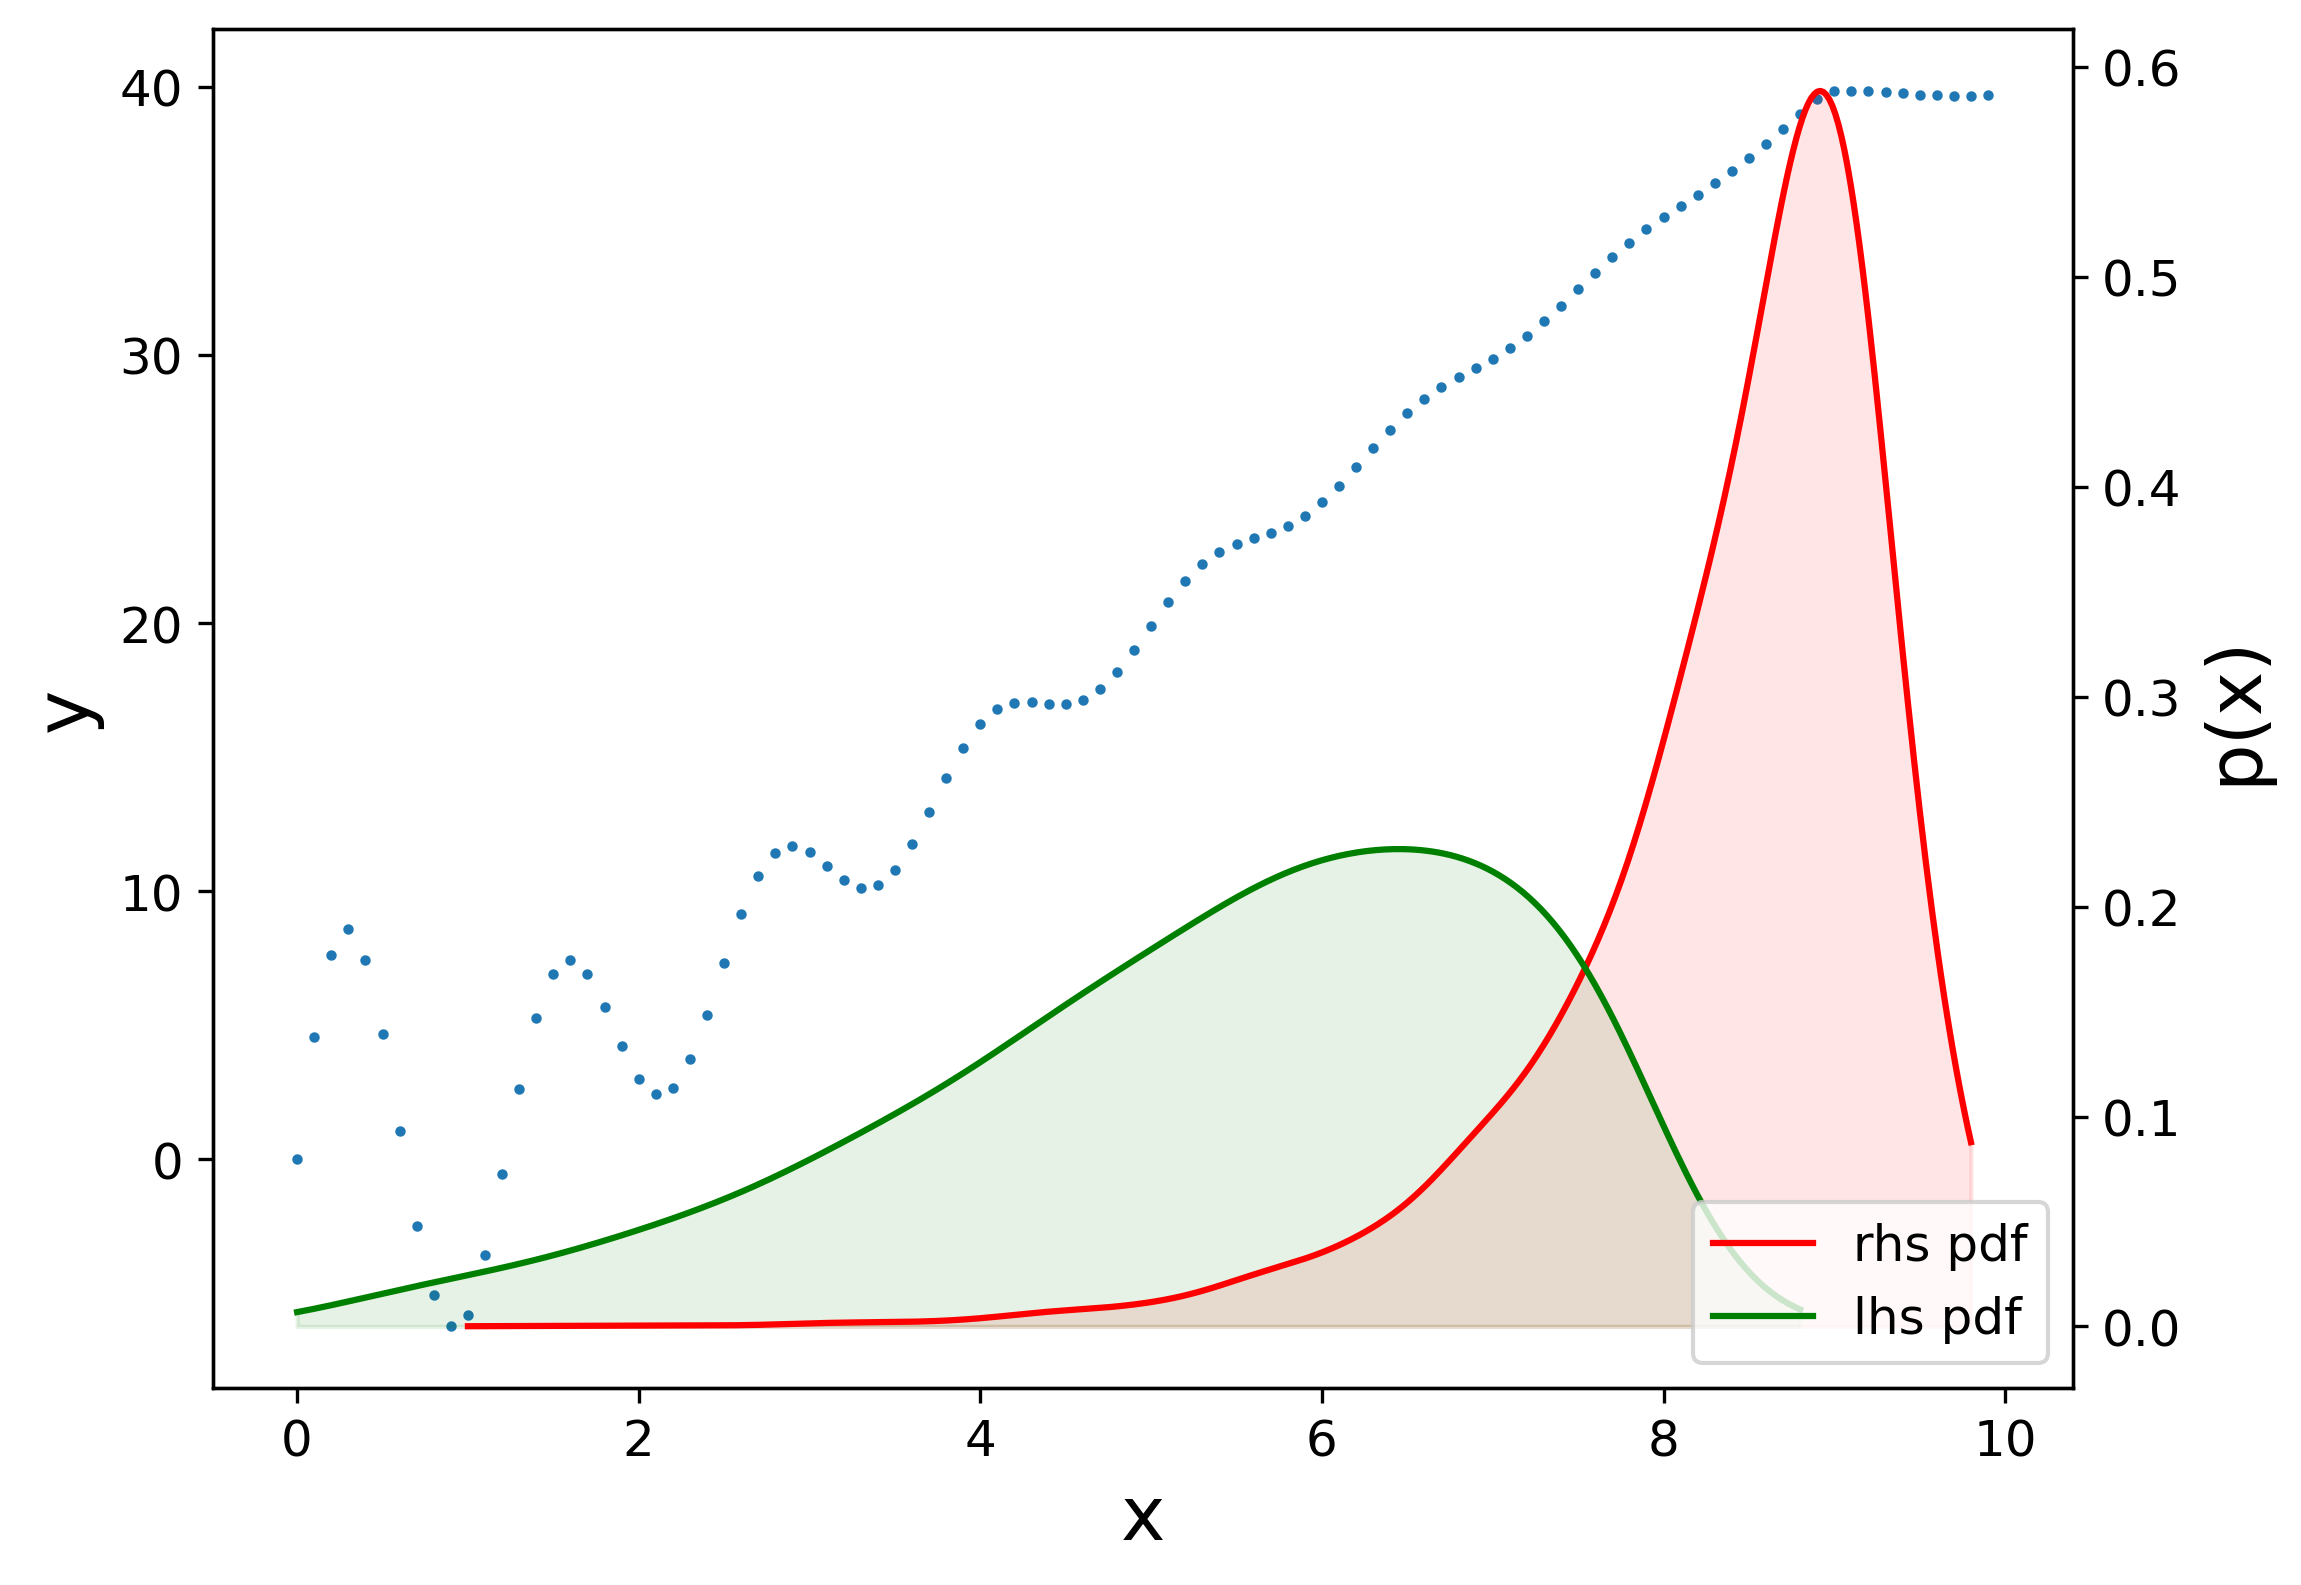

In [11]:
estimate = np.argmax(kernel(positions))
idx = np.where(np.abs(slope - positions[estimate]) < 2000)[0]

plt.figure(figsize=(8,6), dpi=300)
ax1 = plt.gca()

ax1.plot(region[:,0], region[:,1], '.', ms=3)
ax1.set_ylabel(r'y', fontsize=18)
ax2 = ax1.twinx()
ax2.set_ylabel(r'p(x)', fontsize=18)
rhs_array = region[rhs_arr[idx],0]
kernel = gaussian_kde(rhs_array, weights=weights[idx])
positions = np.linspace(np.min(rhs_array), np.max(rhs_array), num=500)
p = ax2.plot(positions, kernel(positions), color='red', label='rhs pdf')
ax2.fill_between(positions, kernel(positions), color='red', alpha=.1)
print('RHS Estimate = %.2f' % (positions[np.argmax(kernel(positions))]))

lhs_array = region[lhs_arr[idx],0]
kernel = gaussian_kde(lhs_array, weights=weights[idx])
positions = np.linspace(np.min(lhs_array), np.max(lhs_array), num=500)
p = ax2.plot(positions, kernel(positions), color='green', label='lhs pdf')
ax2.fill_between(positions, kernel(positions), color='green', alpha=.1)
ax1.set_xlabel(r'x', fontsize=18)
ax1.tick_params(axis="x", labelsize=12)
ax1.tick_params(axis="y", labelsize=12)
ax2.tick_params(axis="y", labelsize=12)
ax2.legend(loc='lower right')
print('LHS Estimate = %.2f' % (positions[np.argmax(kernel(positions))]))

plt.savefig(output_dir + "/toy_example_bounds.png")

### Visualize the slopes and the fitting weight of each fit in the ensemble. 

For each point (LHS, RHS), the color represents the slope, and the size of the marker 
represents the fitting weight (described above) 

(4005,) (4005,) (4005,)
[-12.08269664 -12.62087293 -11.58226561 ...   1.03748015   0.83352173
   0.36320519]


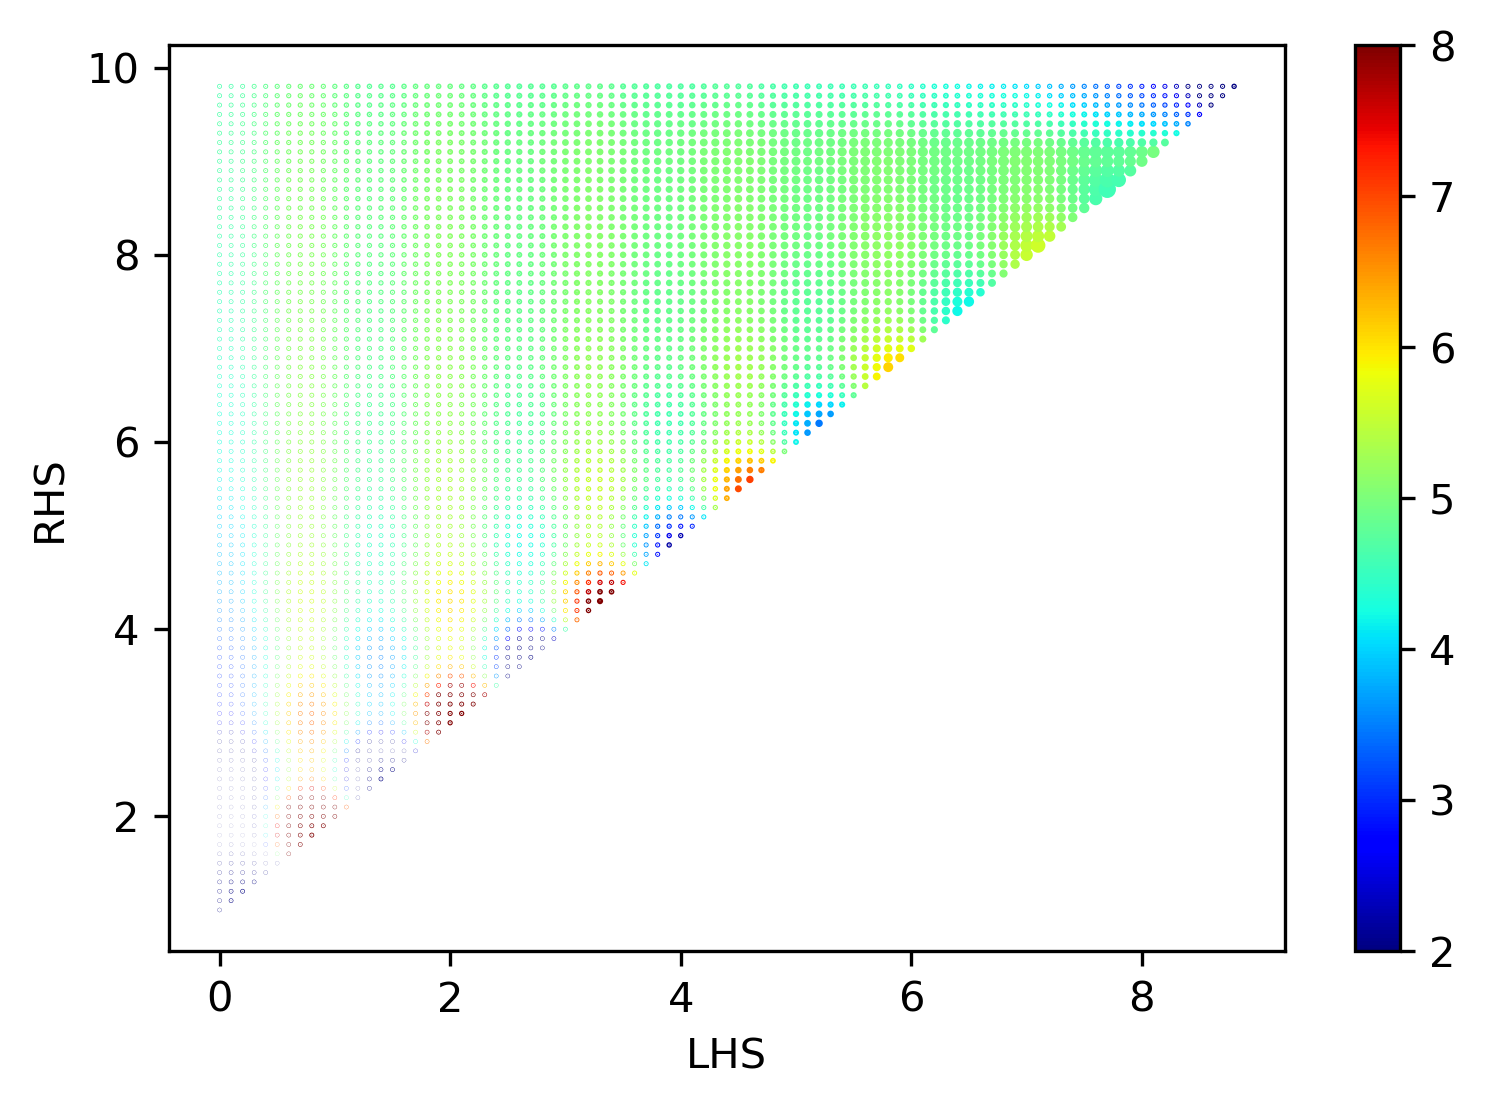

In [11]:
print(slope.shape, weights.shape, lhs_arr.shape)
plt.figure(dpi=300)
plt.scatter(region[lhs_arr,0], region[rhs_arr,0], s=10*(weights[idx]/np.max(weights[idx])),c=slope[idx], cmap=plt.cm.jet)#, '.', c = weights[idx], markersize=1)
plt.xlabel('LHS')
plt.ylabel('RHS')
plt.colorbar()
#plt.xlim([-5,5])
#plt.ylim([-5,5])
plt.clim([2,8])
plt.savefig(output_dir + '/toy_example_2d_plot.png')

print(slope[idx])